# STEP 1 

In [1]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def asciiDC3 (seq) : 
    asc=[]
    for i in seq : 
        asc.append(ord(i))
    
    return asc+[0,0,0]

In [3]:
def position1_2 (asc):
    ind1=[]
    ind2=[]
    for k in range(len(asc)-2):
        #attention on a peut etre fait de la merde ici, pas sure du -2
        if k%3==1 :
            ind1.append(k)
        if k%3==2:
            ind2.append(k)
    # dans le cas où T a un nombre d'élément multiple de 3, r12 ne contiendra pas le triplet [0,0,0].
    # Or, la fonction, "removesentinel" retire 1 élément notre suffix table, pour justement se débarrasser de [0,0,0]
    # J'ai donc décider de rajouter artificiellement [0,0,0] dans les cas où il n'est pas déjà là.
    if len(asc)%3==0:
        ind1.append(len(asc)-1-2)
        
    return ind1+ind2

In [4]:
def radix_with_p12(p,t):
    r=[]
    for i in range(len(p)):
        index=p[i]
        r.append([[t[index],t[index+1], t[index+2]],index])
    return r

In [5]:
def sort_with_p12(array, alphabet, columnNumber):
    #print("array")
    #print(array)
    #print("alphabet")
    #print(alphabet)
    if len(array) == 0:
        return array

  # Perform counting sort on each column, starting at the last

    column = columnNumber
    while column>=0: # nous on met "tant que l'indice est supérieur à 3"
        array = countingSortByDigit_with_p12(array, alphabet, column)
        column-=1 #change de colonne dans ton tableau

    return array

def countingSortByDigit_with_p12(array, alphabet, column):
    """
    ici possibleNumbers= nombre de chiffres possibles. Nous n'avons que 4 nombres (0,97,98,99)
    """

    countIndex = -1
    count = [0] * len(alphabet)
    output = [None] * len(array)

  # Count frequencies
    for i in range(0, len(array)):
        #print("i "+str(i))
        #print("array[i] "+ str(array[i]))
        #print("column "+str(column))
        
        countIndex = alphabet[array[i][0][column]]
        count[countIndex] += 1

  # Compute cumulates
    for i in range(1, len(alphabet)):
        count[i] += count[i - 1]

  # Move records
    for i in range(len(array) - 1, -1, -1):
        countIndex = alphabet[array[i][0][column]]
        count[countIndex] -= 1
        output[count[countIndex]] = array[i]
       
    return output

In [6]:
def triplets_are_equal(a,b):
    for i in range(len(a)):
        if a[i]!=b[i]:
            return False
    return True


def ordre_with_p12(R12p12sorted, use_index_12=False):
    # nous renovie la liste order du genre (1,2,2,3,4,4,5)  et un booléen indiquant s'il y a répétition
    index=1
    repetition=False
    order=[1]
    
    if use_index_12:
        indexdict={R12p12sorted[0][1]:1}
        
    for i in range(1, len(R12p12sorted)): 
        if triplets_are_equal(R12p12sorted[i-1][0], R12p12sorted[i][0]):
            order.append(index)
            repetition=True
        else : 
            index+=1
            order.append(index)
            
        if use_index_12:
            indexdict[R12p12sorted[i][1]]=order[i]
    if use_index_12:
        return order, repetition, indexdict
    else: 
        return order
            

In [7]:
def alphabetT(T):
    ### à changer pcq c laid
    dic={}
    a=[]
    for i in range(len(T)):
        a.append(T[i])
    a.sort() ## MDR CE SORT EST A CHANGER SERGIO VA NOUS TUER
    
    for element in a:
        if not (element in dic):
            dic[element]=len(dic)
    return dic

In [8]:
def alphabetR0_with_p12(R0p0):
    ### à changer pcq c laid
    dic={}
    a=[]
    for column in range(2):
        for i in range(len(R0p0)):
            a.append(R0p0[i][0][column])
    a.sort() ## MDR CE SORT EST A CHANGER SERGIO VA NOUS TUER
    
    for element in a:
        if not (element in dic):
            dic[element]=len(dic)
    return dic

In [9]:
def Tprime_with_p12(p12, indexdict):
    t=[]
    for p in p12:
        t.append(indexdict[p])
    return t

In [10]:
def position0_R0_p0(T, index12dict):
    #attention T se finit avec trois 0
    #print("T")
    #print(T)
    position=[]
    R=[]
    for i in range(len(T)-3): #on ne prend pas en compte les trois 0 sentinelle
        if i%3==0:
            position.append(i)
            if i+1<len(T)-3:
                #print("i")
                #print(i)
                #print("T[i+1]")
                #print(T[i+1])
                R.append([[T[i],index12dict[i+1]],position[-1]])
            else:
                R.append([[T[i],1],position[-1]]) # car les sentinelles sont forcément les 1ères dans l'ordre alphabétique
    return position, R

In [11]:
def merge_with_p12(Tfinal, r0p0sorted, index12dict) : 
    index12dictkeys=list(index12dict.keys())
    liste=[]
    A=0
    B=0
    while A<len(r0p0sorted) and B<len(index12dictkeys):
        a=r0p0sorted[A][1]
        b=index12dictkeys[B]
        if Tfinal[a]!=Tfinal[b] :
            minimum=min(Tfinal[a], Tfinal[b])
            
            if minimum == Tfinal[a]:
                A+=1
                liste.append(a)
            else: 
                B+=1
                liste.append(b)

        else :
            if b%3==1 : 
                longueur=len(liste)
                i=0
                if index12dict[a+1]<index12dict[b+1]:
                    liste.append(a)
                
                    A+=1
                else:
                    liste.append(b)
                
                    B+=1
                    
                    
            elif b%3==2 :
            
                if Tfinal[a+1]!=Tfinal[b+1] :
                   
                    minimum=min(Tfinal[a+1], Tfinal[b+1])
                    if minimum == Tfinal[a+1]:
                        A+=1
                    
                        liste.append(a)
                    else: 
                        B+=1
                        
                        liste.append(b)

                else:
                  
                    if index12dict[a+2]<index12dict[b+2]:
                        liste.append(a)
                        A+=1
                    else:
                        liste.append(b)
                        B+=1
                        

    if A==len(r0p0sorted):

        for i in range(B,len(index12dictkeys)):
            liste.append(index12dictkeys[i])
                
    if B==len(index12dictkeys):

        for i in range(A, len(r0p0sorted)):
            liste.append(r0p0sorted[i][1])

    return liste

In [12]:
def merge_with_p12_debugg(Tfinal, r0p0sorted, index12dict) : 
    print("rappel des paramètres entrés pour la fonction merge")
    print("Tfinal")
    print(Tfinal)
    print("r0p0sorted")
    print(r0p0sorted)
    print("index12dict")
    print(index12dict)
    print("on construit une liste des clés du dictionnaire")
    print("qui est dans l'ordre normalement ahhh!")
    index12dictkeys=list(index12dict.keys())
    liste=[]
    A=0
    B=0
    while A<len(r0p0sorted) and B<len(index12dictkeys):
        print("rentre dans le while")
        a=r0p0sorted[A][1]
        b=index12dictkeys[B]
        if Tfinal[a]!=Tfinal[b] :
            minimum=min(Tfinal[a], Tfinal[b])
            
            if minimum == Tfinal[a]:
                print("a= "+str(a)+", b= "+str(b)+", on append le "+str(a))
                A+=1
                liste.append(a)
            else: 
                print("a= "+str(a)+", b= "+str(b)+", on append le "+str(b))
                B+=1
                liste.append(b)

        else :
            print("Tfinal[a]")
            print(Tfinal[a])
            print("Tfinal[b]")
            print(Tfinal[b])
            print("Tfinal[a]==Tfinal[b]")
            print(Tfinal[a]==Tfinal[b])
            if b%3==1 : 
                print(str(b)+" est congru à 1 modulo 3")
                longueur=len(liste)
                print("l'objet liste est pour l'instant constitué de: ")
                print(liste)
                i=0
                print("on compare les positions de "+str(a+1)+" et "+str(b+1))
                print("index12dict[" +str(a+1)+"]= ")
                print(index12dict[a+1])
                print("index12dict[" +str(b+1)+"]= ")
                print(index12dict[b+1])
                if index12dict[a+1]<index12dict[b+1]:
                    liste.append(a)
                    print("on append "+ str(a))
                    A+=1
                else:
                    liste.append(b)
                    print("on append "+ str(b))
                    B+=1
                    
                    
            elif b%3==2 :
                print(str(b)+"est congru à 2 modulo 3")
                if Tfinal[a+1]!=Tfinal[b+1] :
                    print("Tfinal[a+1]")
                    print(Tfinal[a+1])
                    print("Tfinal[b+1]")
                    print(Tfinal[b+1])
                    print("Tfinal[a+1]!=Tfinal[b+1]")
                    print(Tfinal[a+1]!=Tfinal[b+1])
                    minimum=min(Tfinal[a+1], Tfinal[b+1])
                    if minimum == Tfinal[a+1]:
                        A+=1
                        print("on append "+ str(a))
                        liste.append(a)
                    else: 
                        B+=1
                        print("on append "+ str(b))
                        liste.append(b)

                else:
                    print("Tfinal[a+1]")
                    print(Tfinal[a+1])
                    print("Tfinal[b+1]")
                    print(Tfinal[b+1])
                    print("Tfinal[a+1]==Tfinal[b+1]")
                    print(Tfinal[a+1]==Tfinal[b+1])
                    print("on compare a+2 et b+2")
                    if index12dict[a+2]<index12dict[b+2]:
                        liste.append(a)
                        A+=1
                    else:
                        liste.append(b)
                        B+=1
                        
    print("plus dans la boucle while")
    print("A "+str(A))
    print("B "+str(B))
    if A==len(r0p0sorted):
        print("on concatène les index12")
        for i in range(B,len(index12dictkeys)):
            liste.append(index12dictkeys[i])
                
    if B==len(index12dictkeys):
        print("on concatène les index0")
        for i in range(A, len(r0p0sorted)):
            liste.append(r0p0sorted[i][1])

    return liste

In [13]:
def removesentinel(index):
    return index[1:]

In [14]:
def resumeHigherOrder_with_p12(index012prime, P12):
    output={}
    for i in range(len(index012prime)):
        output[P12[index012prime[i]]]=i
        
    return output

### test zone avec test 2

In [15]:
test_2='ATGCTAGCTGCCCTGATCTCTCTGA!'
p12_test_2=[1, 4, 7, 10, 13, 16, 19, 22, 25, 2, 5, 8, 11, 14, 17, 20, 23, 26]
r12_test_2=[[84, 71, 67], [84, 65, 71], [67, 84, 71], [67, 67, 67], [84, 71, 65], [84, 67, 84], [67, 84, 67], [84, 71, 65], [33, 0, 0], [71, 67, 84], [65, 71, 67], [84, 71, 67], [67, 67, 84], [71, 65, 84], [67, 84, 67], [84, 67, 84], [71, 65, 33], [0, 0, 0]]
alphabet_test_2={0: 0, 33: 1, 65: 2, 67: 3, 71: 4, 84: 5}


r12_p12_test_2=radix_with_p12(p12_test_2,asciiDC3(test_2))
print(r12_p12_test_2)



[[[84, 71, 67], 1], [[84, 65, 71], 4], [[67, 84, 71], 7], [[67, 67, 67], 10], [[84, 71, 65], 13], [[84, 67, 84], 16], [[67, 84, 67], 19], [[84, 71, 65], 22], [[33, 0, 0], 25], [[71, 67, 84], 2], [[65, 71, 67], 5], [[84, 71, 67], 8], [[67, 67, 84], 11], [[71, 65, 84], 14], [[67, 84, 67], 17], [[84, 67, 84], 20], [[71, 65, 33], 23], [[0, 0, 0], 26]]


In [16]:
r12_p12_sorted=sort_with_p12(r12_p12_test_2, alphabet_test_2, 2)
print(r12_p12_sorted)

[[[0, 0, 0], 26], [[33, 0, 0], 25], [[65, 71, 67], 5], [[67, 67, 67], 10], [[67, 67, 84], 11], [[67, 84, 67], 19], [[67, 84, 67], 17], [[67, 84, 71], 7], [[71, 65, 33], 23], [[71, 65, 84], 14], [[71, 67, 84], 2], [[84, 65, 71], 4], [[84, 67, 84], 16], [[84, 67, 84], 20], [[84, 71, 65], 13], [[84, 71, 65], 22], [[84, 71, 67], 1], [[84, 71, 67], 8]]


In [17]:
print(r12_p12_sorted[5][0])
print(r12_p12_sorted[6][0])
print(triplets_are_equal(r12_p12_sorted[5][0],r12_p12_sorted[6][0]))
ordre_test_2, repetition, indexdict_test_2=ordre_with_p12(r12_p12_sorted, True)
print(ordre_test_2)
print(indexdict_test_2)

[67, 84, 67]
[67, 84, 67]
True
[1, 2, 3, 4, 5, 6, 6, 7, 8, 9, 10, 11, 12, 12, 13, 13, 14, 14]
{26: 1, 25: 2, 5: 3, 10: 4, 11: 5, 19: 6, 17: 6, 7: 7, 23: 8, 14: 9, 2: 10, 4: 11, 16: 12, 20: 12, 13: 13, 22: 13, 1: 14, 8: 14}


In [18]:
p0, R0_p0_test_2=position0_R0_p0(asciiDC3(test_2), indexdict_test_2)

print(p0)
print(R0_p0_test_2)

alphabet_r0_test_2=alphabetR0_with_p12(R0_p0_test_2)
print(alphabet_r0_test_2)
    
r0p0sorted=sort_with_p12(R0_p0_test_2,alphabet_r0_test_2 ,1)
print(r0p0sorted)

order0=ordre_with_p12(r0p0sorted)
    

[0, 3, 6, 9, 12, 15, 18, 21, 24]
[[[65, 14], 0], [[67, 11], 3], [[71, 7], 6], [[71, 4], 9], [[67, 13], 12], [[65, 12], 15], [[84, 6], 18], [[67, 13], 21], [[65, 2], 24]]
{2: 0, 4: 1, 6: 2, 7: 3, 11: 4, 12: 5, 13: 6, 14: 7, 65: 8, 67: 9, 71: 10, 84: 11}
[[[65, 2], 24], [[65, 12], 15], [[65, 14], 0], [[67, 11], 3], [[67, 13], 12], [[67, 13], 21], [[71, 4], 9], [[71, 7], 6], [[84, 6], 18]]


### test zone avec abcabcabc

In [19]:
S="abcabcacab"
T=asciiDC3(S)
columnnumber=2
print(T)


[97, 98, 99, 97, 98, 99, 97, 99, 97, 98, 0, 0, 0]


In [20]:
p12=position1_2(T)
print(p12)
R12=radix_with_p12(p12, T)
print(R12)
alph=alphabetT(T)
alph
Rs12= sort_with_p12(R12, alph, columnnumber)
print(Rs12)

use_index12=True
order12, boolean, index12dict =ordre_with_p12(Rs12,use_index12)
print(order12)
print(boolean)
print(index12dict)

tprime=Tprime_with_p12(p12, index12dict)
print(tprime)

tprime=tprime+[0,0,0]
tprime

[1, 4, 7, 10, 2, 5, 8]
[[[98, 99, 97], 1], [[98, 99, 97], 4], [[99, 97, 98], 7], [[0, 0, 0], 10], [[99, 97, 98], 2], [[99, 97, 99], 5], [[97, 98, 0], 8]]
[[[0, 0, 0], 10], [[97, 98, 0], 8], [[98, 99, 97], 1], [[98, 99, 97], 4], [[99, 97, 98], 7], [[99, 97, 98], 2], [[99, 97, 99], 5]]
[1, 2, 3, 3, 4, 4, 5]
True
{10: 1, 8: 2, 1: 3, 4: 3, 7: 4, 2: 4, 5: 5}
[3, 3, 4, 1, 4, 5, 2]


[3, 3, 4, 1, 4, 5, 2, 0, 0, 0]

In [21]:
p12prime=position1_2(tprime)
print(p12prime)
R12prime=radix_with_p12(p12prime, tprime)
print(R12prime)
alphprime=alphabetT(tprime)
print(alphprime)
Rs12prime= sort_with_p12(R12prime, alphprime, columnnumber)
print(Rs12prime)

order12prime, boolean, index12primedict =ordre_with_p12(Rs12prime, True)
print(order12prime)
print(boolean)
print(index12primedict)

[1, 4, 7, 2, 5]
[[[3, 4, 1], 1], [[4, 5, 2], 4], [[0, 0, 0], 7], [[4, 1, 4], 2], [[5, 2, 0], 5]]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
[[[0, 0, 0], 7], [[3, 4, 1], 1], [[4, 1, 4], 2], [[4, 5, 2], 4], [[5, 2, 0], 5]]
[1, 2, 3, 4, 5]
False
{7: 1, 1: 2, 2: 3, 4: 4, 5: 5}


In [22]:
p0prime, r0prime=position0_R0_p0(tprime, index12primedict)
print(p0prime)
print(r0prime)

[0, 3, 6]
[[[3, 2], 0], [[1, 4], 3], [[2, 1], 6]]


In [23]:
alph0prime=alphabetR0_with_p12(r0prime)
print(alph0prime)
r0sprime= sort_with_p12(r0prime, alph0prime, columnnumber-1)
print(r0sprime)

index120prime=merge_with_p12(tprime, r0sprime, index12primedict)
index120prime

{1: 0, 2: 1, 3: 2, 4: 3}
[[[1, 4], 3], [[2, 1], 6], [[3, 2], 0]]


[7, 3, 6, 0, 1, 2, 4, 5]

# Assemblage final

In [24]:
def almost_dc3_with_p12(T):
    # T est une liste de int

    
    columnNumber=2
    p12=position1_2(T)
    r12=radix_with_p12(p12,T)
    alphabet_T=alphabetT(T)
    r12sorted=sort_with_p12(r12, alphabet_T, columnNumber)    
    order12,repetition, index12dict=ordre_with_p12(r12sorted, True)
    if repetition:
        Tprim=Tprime_with_p12(p12, index12dict)+[0,0,0]
        index012=almost_dc3_with_p12(Tprim)
        index12dict=resumeHigherOrder_with_p12(index012, p12)
    p0,r0p0=position0_R0_p0(T, index12dict)
    alphabet_r0=alphabetR0_with_p12(r0p0)
    r0sorted=sort_with_p12(r0p0,alphabet_r0 ,columnNumber-1)
    index012=removesentinel(merge_with_p12(T, r0sorted, index12dict))
    
    return index012
   
    
    

In [25]:
def almost_dc3_with_p12_debugg(T):
    # T est une liste de int

    
    columnNumber=2
    p12=position1_2(T)
    
    print("p12")
    print(p12)
    print("taille de p12 avant récursion")
    print(len(p12))
    print("\n")
    
    r12=radix_with_p12(p12,T)
    print("r12")
    print(r12)
    print("\n")

    alphabet_T=alphabetT(T)
    print("alphabet de T")
    print(alphabet_T)
    
    r12sorted=sort_with_p12(r12, alphabet_T, columnNumber)
    print("r12sorted")
    print(r12sorted)
    print("\n")
    
    order12,repetition, index12dict=ordre_with_p12(r12sorted, True)
    print("order12")
    print(order12)
    print("index12dict")
    print(index12dict)
    print("entre-t-on dans la boucle de répétition?")
    print(repetition)
    print("\n")
    

    if repetition:

        
        Tprim=Tprime_with_p12(p12, index12dict)+[0,0,0]
        print("tprime")
        print(Tprim)
        print("taille de tprime")
        print(len(Tprim))
        print("\n")
        
        index012=almost_dc3_with_p12_debugg(Tprim)
        print("index012")
        print(index012)
        print("taille de index012")
        print(len(index012))
        print("\n")

        index12dict=resumeHigherOrder_with_p12(index012, p12)
        print("resume higher order index12dict")
        print(index12dict)
        print("taille de index12dict après retour à taille initiale")
        print(len(index12dict))
        print("\n")

    p0,r0p0=position0_R0_p0(T, index12dict)
    print("rappel de T")
    print(T)
    print("r0p0")
    print(r0p0)
    print("taille de r0p0")
    print(len(r0p0))
    print("\n")

    alphabet_r0=alphabetR0_with_p12(r0p0)
    print("alphabet_r0")
    print(alphabet_r0)
    print("\n")
    
    r0sorted=sort_with_p12(r0p0,alphabet_r0 ,columnNumber-1)
    print("r0sorted")
    print(r0sorted)
    print("taille de r0sorted")
    print(len(r0sorted))
    print("\n")

    #order0=ordre(r0sorted, index12)
    
    
    index012=removesentinel(merge_with_p12(T, r0sorted, index12dict))
    print("taille après la fonction removesentinel")
    print(len(index012))
    print("rappel de T")
    print(T)
    print("index012")
    print(index012)
    print("\n")
    
    for i in range(len(index012)):
        print(T[index012[i]:])
    
    return index012
   
    
    

## Test avec biopython 


In [26]:
pip install biopython

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
from Bio import SeqIO
genome=[]
nucleotide_genome=0
for seq_record in SeqIO.parse("/home/azarkua/Documents/2023-2024/omiques2/developement/omique2/genome.fna", "fasta"):
    genome.append(seq_record)
    nucleotide_genome+=len(seq_record.seq)
print(genome[13:])

[SeqRecord(seq=Seq('tgaaccctaaaccctaaaccctaaaccctaaacccctaaaccctaaaccctgaa...gtt'), id='NC_037283.1', name='NC_037283.1', description='NC_037283.1 Plasmodium falciparum 3D7 genome assembly, chromosome: 14', dbxrefs=[]), SeqRecord(seq=Seq('ATGATAAAATTTTTAAAACCTAAAATAAAAATATTAAAAAAATTAAATATACCT...ATT'), id='NC_036769.1', name='NC_036769.1', description='NC_036769.1 Plasmodium falciparum strain 3D7, apicoplast', dbxrefs=[])]


In [28]:
reads=[]
nucleotide_reads=0
for seq_record in SeqIO.parse("/home/azarkua/Documents/2023-2024/omiques2/developement/omique2/reads.fq", "fastq"):
    reads.append(seq_record)
    nucleotide_reads+=len(seq_record.seq)
    #if len(seq_record.seq)!= 100:
    #    print("False")
print(reads[:1])

[SeqRecord(seq=Seq('TTTCCTTTTTAAGCGTTTTATTTTTTAATAAAAAAAATATAGTATTATATAGTA...TAA'), id='NC_004325.2-100000', name='NC_004325.2-100000', description='NC_004325.2-100000', dbxrefs=[])]


In [29]:
temp=genome[1].seq.upper()
print(len(temp)//4)
temp[50:60]

236775


Seq('CCCTGAACCC')

Pour l'instant, notre code met environ 2min d'attente pour faire la suffix table de 25 000 nucléotides.

In [30]:
T=asciiDC3(temp)
#print(T)

In [31]:
suffix_array=almost_dc3_with_p12(T)
print(suffix_array[:100])
#print(timemeasuring)

[947101, 468510, 633566, 468511, 434614, 207415, 633567, 468512, 434615, 207416, 633568, 388233, 468513, 434616, 207417, 633569, 724610, 388234, 468514, 434617, 207418, 633570, 724611, 388235, 468515, 434618, 207419, 533168, 633571, 724612, 388236, 468516, 434619, 207420, 533169, 633572, 238221, 724613, 441106, 388237, 468517, 434620, 207421, 533170, 684120, 633573, 422507, 238222, 656252, 724614, 441107, 157882, 388238, 468518, 654531, 434621, 369055, 207422, 533171, 684121, 633574, 422508, 238223, 656253, 724615, 172540, 441108, 157883, 576520, 388239, 468519, 654532, 434622, 369056, 207423, 247439, 458613, 481497, 533172, 684122, 633575, 168552, 422509, 238224, 656254, 724616, 172541, 441109, 157884, 576521, 388240, 468520, 654533, 699572, 434623, 369057, 521750, 207424, 247440, 458614]


## Mesurer le temps que prend notre fonction

In [32]:
import pstats
import cProfile

In [33]:
cProfile.run("almost_dc3_with_p12(T)", "dc3_stats")
p = pstats.Stats("dc3_stats")
p.sort_stats("cumulative").print_stats()

Fri Nov  3 12:14:20 2023    dc3_stats

         28452198 function calls (28452193 primitive calls) in 23.766 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   23.766   23.766 {built-in method builtins.exec}
        1    0.425    0.425   23.766   23.766 <string>:1(<module>)
      6/1    1.076    0.179   23.340   23.340 /tmp/ipykernel_6565/3778850517.py:1(almost_dc3_with_p12)
       12    0.138    0.012    7.340    0.612 /tmp/ipykernel_6565/2101628537.py:1(sort_with_p12)
       30    7.202    0.240    7.202    0.240 /tmp/ipykernel_6565/2101628537.py:18(countingSortByDigit_with_p12)
        6    3.446    0.574    4.037    0.673 /tmp/ipykernel_6565/4110635339.py:1(merge_with_p12)
        6    3.405    0.568    3.487    0.581 /tmp/ipykernel_6565/2868372930.py:1(radix_with_p12)
        6    1.460    0.243    2.493    0.415 /tmp/ipykernel_6565/2442398083.py:8(ordre_with_p12)
        6    1.108    0.18

### Idées d'optimisation  
-réussir à ne plus faire appel aux fonctions "alphabet"  

### BWT à l'aide de notre suffix table

In [34]:
def BWT_suffix_table(T,end_of_string=False):
    """
    Compute the BWT from the suffix table
    
    Args:
        T (str): string
        end_of_string (char): end of string character to append
    
    Return:
        bwt (str): BWT
    """
    if end_of_string==False:
        T += '!'
    suffix_array=almost_dc3_with_p12(asciiDC3(T)) 
    bwt = ""
    for i in suffix_array:
        bwt += T[i-1]
    return(bwt)

In [35]:
def run_length_encoding(S):
    """
    Encode sequence using the Run Length method
    
    Args:
        text (str): string to be shifted
    
    Return:
        str: run length
    """
    encoded_S= ""
    i=0
    number=1
    while i<len(S):
        encoded_S+=S[i]
        i+=1
        while i<len(S) and S[i-1]==S[i]:
            number+=1
            i+=1
        if number>1:
            encoded_S+=str(number)
        number=1
    return encoded_S

#### Testons notre fonction

In [36]:
test_2='ATGCTAGCTGCCCTGATCTCTCTGA!'
suffix_array_2_with_p12=almost_dc3_with_p12(asciiDC3(test_2)) 
print(suffix_array_2_with_p12)


[25, 24, 5, 15, 0, 10, 11, 3, 17, 19, 21, 12, 7, 23, 14, 9, 2, 6, 4, 16, 18, 20, 22, 13, 8, 1]


In [37]:
for i in range(len(suffix_array_2_with_p12)):
    print(test_2[suffix_array_2_with_p12[i]:])
  

!
A!
AGCTGCCCTGATCTCTCTGA!
ATCTCTCTGA!
ATGCTAGCTGCCCTGATCTCTCTGA!
CCCTGATCTCTCTGA!
CCTGATCTCTCTGA!
CTAGCTGCCCTGATCTCTCTGA!
CTCTCTGA!
CTCTGA!
CTGA!
CTGATCTCTCTGA!
CTGCCCTGATCTCTCTGA!
GA!
GATCTCTCTGA!
GCCCTGATCTCTCTGA!
GCTAGCTGCCCTGATCTCTCTGA!
GCTGCCCTGATCTCTCTGA!
TAGCTGCCCTGATCTCTCTGA!
TCTCTCTGA!
TCTCTGA!
TCTGA!
TGA!
TGATCTCTCTGA!
TGCCCTGATCTCTCTGA!
TGCTAGCTGCCCTGATCTCTCTGA!


In [38]:
print(BWT_suffix_table(test_2, True))

AGTG!GCGTTTCGTTTTACACCCCCA


In [39]:
print(run_length_encoding(BWT_suffix_table(test_2, True)))

AGTG!GCGT3CGT4ACAC5A


BWT sur notre génome

In [40]:
bwt_T=BWT_suffix_table(genome[1].seq.upper())
print(run_length_encoding(bwt_T)[:100])

ACT2AT2A5TA4CA10GA8TACA5CATACA2TA2TAGA8CA2CA6G2CA3GA11CA2TA12TA3TA4TA4TA5CA13CA2TA3CA3TA7CA3TA6TGTA2


Mesurons le temps que l'opération prend

In [41]:
cProfile.run("run_length_encoding(BWT_suffix_table(genome[1].seq.upper()))", "bwt_stats")
p = pstats.Stats("bwt_stats")
p.sort_stats("cumulative").print_stats()

Fri Nov  3 12:15:14 2023    bwt_stats

         38466892 function calls (38466887 primitive calls) in 29.341 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   29.341   29.341 {built-in method builtins.exec}
        1    0.033    0.033   29.341   29.341 <string>:1(<module>)
        1    0.758    0.758   28.845   28.845 /tmp/ipykernel_6565/2127043640.py:1(BWT_suffix_table)
      6/1    1.111    0.185   26.481   26.481 /tmp/ipykernel_6565/3778850517.py:1(almost_dc3_with_p12)
       12    0.144    0.012    7.852    0.654 /tmp/ipykernel_6565/2101628537.py:1(sort_with_p12)
       30    7.708    0.257    7.708    0.257 /tmp/ipykernel_6565/2101628537.py:18(countingSortByDigit_with_p12)
        6    3.587    0.598    4.188    0.698 /tmp/ipykernel_6565/4110635339.py:1(merge_with_p12)
        6    3.386    0.564    3.520    0.587 /tmp/ipykernel_6565/3786488779.py:1(position0_R0_p0)
        6    3.326    0

## String search with BWT

version du prof

In [132]:
from collections import Counter

In [133]:
Counter(BWT_suffix_table(test_2))

Counter({'!': 2, 'A': 4, 'G': 5, 'T': 8, 'C': 8})

In [134]:
def last2first(counts,k,X):
    return k + sum([counts[char] for char in counts if char < X])
    
def get_first_occurrence(L,X):
    for i,l in enumerate(L):
        if l == X:
            return(i)
        
def occurrence_indexer(S):
    K = []
    last_index = {}
    for s in S:
        if s not in last_index: 
            last_index[s] = 0
        K.append(last_index[s])
        last_index[s] += 1
    return(K)
    
    



In [135]:
def pattern_matching_BWT(S, pattern,end_pattern=False):
    """
    Search a pattern in a String using the BWT
    
    Args:
        S (str): string
        pattern (str): pattern
    
    Return:
        bool: true if the pattern is in the string 
        
    """
    output=0
    L = BWT_suffix_table(S,end_pattern)
    K = occurrence_indexer(L)
    counts = Counter(L)
    e = 0
    f = len(L)
    i = len(pattern) - 1
    while e < f and i >= 0:
        X = pattern[i]
        first_occurence_in_L_ef = get_first_occurrence(L[e:f],X)
        if first_occurence_in_L_ef is None:
            return False
        else:
            r = first_occurence_in_L_ef+e
        last_occurence_in_L_ef = get_first_occurrence(L[e:f][::-1],X)
        if last_occurence_in_L_ef is None:
            return False
        else:
            s = f-last_occurence_in_L_ef-1
        
        e = last2first(counts,K[r],X)
        f = last2first(counts,K[s],X)+1
        i -= 1
    output=s  
    return [(i<0),output]


In [148]:
def position_of_read(suffix_table, bwt_string_match):
    return suffix_table[bwt_string_match[1]]-1

In [138]:
def last2first_debugg(counts,k,X):
    print("in last2first function")
    print("K")
    print(k)
    print("counts")
    print(counts)
    liste=[]
    for char in counts:
        if char<X:
            liste.append(counts[char])
    somme=sum(liste)
    print("liste obtenue")
    print(liste)
    print("somme")
    print(sum(liste))
    print("\n")
    return k + sum([counts[char] for char in counts if char < X])
    
def pattern_matching_BWT_debugg(S, pattern,end_pattern=False):
    """
    Search a pattern in a String using the BWT
    
    Args:
        S (str): string
        pattern (str): pattern
    
    Return:
        bool: true if the pattern is in the string 
        
    """
    output=0
    L = BWT_suffix_table(S,end_pattern)
    print("bwt")
    print(L)
    K = occurrence_indexer(L)
    print("K")
    print(K)
    counts = Counter(L)
    print("counts")
    print(counts)
    print("\n")
    e = 0
    f = len(L)
    i = len(pattern) - 1
    while e < f and i >= 0:
        X = pattern[i]
        print("on s'intéresse à la lettre")
        print(X)
        first_occurence_in_L_ef = get_first_occurrence(L[e:f],X)
        print("first_occurence_in_L_ef")
        print(first_occurence_in_L_ef)
        if first_occurence_in_L_ef is None:
            return False
        else:
            r = first_occurence_in_L_ef+e

        print("L[e:f]")
        print(L[e:f])
        print("r = first_occurence_in_L_ef+e")
        print(r)
        print("L[r]")
        print(L[r])
        print("\n")
        last_occurence_in_L_ef = get_first_occurrence(L[e:f][::-1],X)
        if last_occurence_in_L_ef is None:
            return False
        else:
            s = f-last_occurence_in_L_ef-1
        print("last_occurence_in_L_ef")
        print(last_occurence_in_L_ef)
        print("L[e:f]")
        print(L[e:f])
        print("s = f-last_occurence_in_L_ef-1")
        print(s)
        print("X")
        print(X)
        print("\n")
        
        
        
        e = last2first(counts,K[r],X)
        print("last2first e")
        print(e)
        print("\n")
        f = last2first(counts,K[s],X)+1
        print("last2first f")
        print(f)
        i -= 1
        print("\n")
    output=s  
    return [(i<0),output]


#### Testons notre fonction

In [141]:
test_2

'ATGCTAGCTGCCCTGATCTCTCTGA!'

In [49]:
pattern_matching_BWT(test_2,'AAA')

False

In [142]:
BWT_suffix_table(test_2, True)

'AGTG!GCGTTTCGTTTTACACCCCCA'

In [143]:
pattern='GATCTC'
match=pattern_matching_BWT(test_2,pattern,True)
print(match)

[True, 3]


In [149]:
st=almost_dc3_with_p12(asciiDC3(test_2))
p=position_of_read(st, match)
test_2[p:p+len(pattern)]

'GATCTC'

In [150]:
testing="GTACGTACCCAGTAGACGTTAGGGTCTCGT!"
pattern_for_testing='CAGTAG'
match_2=pattern_matching_BWT(testing,pattern_for_testing,True)
st_2=almost_dc3_with_p12(asciiDC3(testing))
p_2=position_of_read(st_2, match_2)
testing[p_2:p_2+len(pattern_for_testing)]

'CAGTAG'

### Testons avec notre génome

In [151]:
genome[1].seq.upper()

Seq('AACCCTAAACCCTAAACCCTAAACCCTAAACCCTAAACCCTAAACCTAAACCCT...TCA')

In [152]:
pattern=genome[1].seq.upper()[:10]
pattern

Seq('AACCCTAAAC')

In [154]:
match_genome=pattern_matching_BWT(genome[1].seq.upper(),pattern)
st_genome=almost_dc3_with_p12(asciiDC3(genome[1].seq.upper()))
p_genome=position_of_read(st_genome, match_genome)
genome[1].seq.upper()[p_genome:p_genome+len(pattern)]

Seq('TACCCTAAAT')

In [155]:
print(p_genome)

486998


In [53]:
cProfile.run("pattern_matching_BWT(genome[1].seq.upper(),pattern)", "pattern_matching_stats")
p = pstats.Stats("pattern_matching_stats")
p.sort_stats("cumulative").print_stats()

Fri Nov  3 12:16:04 2023    pattern_matching_stats

         37923423 function calls (37923417 primitive calls) in 29.890 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   29.890   29.890 {built-in method builtins.exec}
        1    0.010    0.010   29.890   29.890 <string>:1(<module>)
        1    0.033    0.033   29.880   29.880 /tmp/ipykernel_6565/3682101168.py:20(pattern_matching_BWT)
        1    0.769    0.769   29.555   29.555 /tmp/ipykernel_6565/2127043640.py:1(BWT_suffix_table)
      6/1    1.195    0.199   27.179   27.179 /tmp/ipykernel_6565/3778850517.py:1(almost_dc3_with_p12)
       12    0.161    0.013    8.209    0.684 /tmp/ipykernel_6565/2101628537.py:1(sort_with_p12)
       30    8.047    0.268    8.048    0.268 /tmp/ipykernel_6565/2101628537.py:18(countingSortByDigit_with_p12)
        6    3.662    0.610    4.272    0.712 /tmp/ipykernel_6565/4110635339.py:1(merge_with_p12)
    

### Première tentative de mesure du temps que prend dc3 (qui ne marche pas)

Mais j'y ai investi trop de temps pour le supprimer

i assume that when a function ends, an other function begins

In [54]:
      #time variables
t0=[] #starting times of every recursion of almost_dc3
timep12=[] 
timer12=[]
timealphabet=[]
timesort=[]
timeorder=[]
trep=[]
timeTprime=[]
tBeforeHigherOrder=[]
timeresumeHigherOrder=[]
tBeforeP0=[]
timeposition0_R0=[]
timealphabetR0=[]
    
timelist=[t0,timep12,timer12,timealphabet,timesort,timeorder,trep,timeTprime,tBeforeHigherOrder,timeresumeHigherOrder,tBeforeP0,timeposition0_R0,timealphabetR0]


In [55]:
def almost_dc3_time_measuring(T):
    
    t0.append(time.time())
    # T est une liste de int
    columnNumber=2
    p12=position1_2(T)
    
    print("p12")
    print(p12)
    print("taille de p12 avant récursion")
    print(len(p12))
    
    timep12.append(time.time()-t0[-1])
    
    r12=radix(p12,T)
    timer12.append(time.time()-timep12[-1])
    
    alphabet_T=alphabetT(T)
    timealphabet.append(time.time()-timer12[-1])
    
    r12sorted, index12=sort(r12, p12, alphabet_T, columnNumber)
    timesort.append(time.time()-timealphabet[-1])
    
    order12,repetition=ordre(r12sorted)
    timeorder.append(time.time()-timesort[-1])
    
    if repetition:
        trep.append(time.time())
        
        Tprim=Tprime(order12, p12, index12)+[0,0,0]
        timeTprime.append(time.time()-trep[-1])
        
        index012=almost_dc3(Tprim)
        
        tBeforeHigherOrder.append(time.time())
        index12=resumeHigherOrder(index012, p12)
        timeresumeHigherOrder.append(time.time()-tBeforeHigherOrder[-1])
    
    print("taille de p12 après récursion")
    print(len(p12))
    
    tBeforeP0.append(time.time())
    p0,r0=position0_R0(T, index12)
    timeposition0_R0.append(time.time()-tBeforeP0[-1])
    
    alphabet_r0=alphabetR0(r0)
    timealphabetR0.append(time.time()-timeposition0_R0[-1])
    
    r0sorted, index0=sort(r0,p0,alphabet_r0 ,columnNumber-1)
    #i dont measure time here
    
    order0=ordre(r0sorted)
    #i dont measure time here
    
    index012=removesentinel(merge(T, index0, index12))
    #i dont measure time here

    return index012, timelist
   
    
    

In [56]:
length_repeating_loop=len(timeTprime)
timeTprime+=[0*i for i in range(len(t0)-length_repeating_loop)]
timeresumeHigherOrder+=[0*i for i in range(len(t0)-length_repeating_loop)]

In [57]:
time_measuring=pd.DataFrame({'p12':timep12, 
                             'r12':timer12, 
                             'alphabet':timealphabet, 
                             'sort':timesort, 
                             'order':timeorder, 
                             'Tprime':timeTprime, 
                             'HigherOrder':timeresumeHigherOrder, 
                             'P0':timeposition0_R0, 
                             'alphabetRO':timealphabetR0})

In [58]:
time_measuring

,p12,r12,alphabet,sort,order,Tprime,HigherOrder,P0,alphabetRO


In [59]:
time_measuring_melted = pd.melt(time_measuring)

<AxesSubplot:>

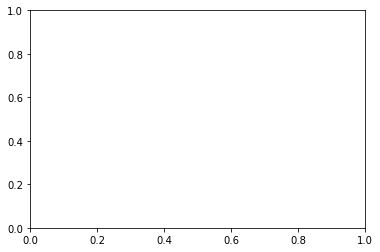

In [60]:
sns.boxplot(x='variable', y='value', data=time_measuring_melted)